# Dense Neural Network for Urban Sound Classificaton using the Log power expectrum

In this notebook we demonstrate the use of [Mel Frequency Spectrum](https://en.wikipedia.org/wiki/Mel_scale)  for a sound classification task. 

We first show that a pure logistic regression model performs quite poorly (41% accuracy), a 2 layer neural network does better.
After some hyperparameter optimization we can achieve a $\approx79\%$ accuracy.

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline
import gzip

import sys
sys.path.append("../..")
from E4525_ML import mnist
from E4525_ML import plots
from E4525_ML.multiclass_logistic import LogisticGDClassifier
from E4525_ML.notebook_utils import get_logger,LoggingCallback

In [2]:
logger=get_logger("DNN_UrbanSounds.log")

### Data

In [3]:
data_dir=r"../../data/UrbanSounds"

In [4]:
file=open(data_dir+"/mfcc.p","rb")
features_all,labels_all=pickle.load(file)

In [5]:
labels_all

array([3, 3, 3, ..., 2, 2, 2])

In [6]:
features,features_test,labels,labels_test=train_test_split(features_all,labels_all,test_size=0.2)
print(features.shape,features_test.shape)

(6316, 20, 173) (1579, 20, 173)


In [7]:
features_train,features_val,labels_train,labels_val=train_test_split(features,labels,test_size=0.2)
print(features_train.shape,features_val.shape)

(5052, 20, 173) (1264, 20, 173)


In [8]:
features_train[0]

array([[-2.35363987e+02, -2.39083086e+02, -2.50423002e+02, ...,
        -2.65910394e+02, -2.65711133e+02, -2.80291934e+02],
       [ 1.19366648e+02,  1.26683337e+02,  1.28170392e+02, ...,
         1.29082176e+02,  1.20021864e+02,  1.17317026e+02],
       [-6.86172278e+01, -6.21786150e+01, -5.37242432e+01, ...,
        -4.13094095e+01, -2.92963672e+01, -2.34803853e+01],
       ...,
       [-7.71124803e+00, -7.94184840e+00, -4.75488919e+00, ...,
        -1.26067720e+01, -2.00893398e+00,  5.29066062e+00],
       [ 9.85458308e+00,  6.87584748e+00,  6.46494105e-02, ...,
        -3.82595303e+00,  3.44026366e+00,  1.22220546e+01],
       [ 1.31098343e+00,  2.22566909e+00, -1.64812632e+00, ...,
        -3.13224279e+00, -7.84951576e+00, -5.96955425e+00]])

## Logistic Classifier

### Explicit Logistic Classifier

In [9]:
model=LogisticGDClassifier(max_iter=5000,learning_rate=0.001,penalty=0,verbose=True)

In [10]:
model.fit(features_train.reshape(len(features_train),-1),labels_train,features_val.reshape(len(features_val),-1),labels_val)
Y_pred=model.predict(features_train.reshape(len(features_train),-1))
"Training accuracy",np.mean(Y_pred==labels_train)

	 0 Loss = 19191.74885646587 Train_Accuracy 0.118 Evaluation Loss = 19079.56305561321 Accuracy = 0.118
	 500 Loss = 9026.133564536658 Train_Accuracy 0.608 Evaluation Loss = 12884.020132896903 Accuracy = 0.44
	 1000 Loss = 4490.040931338389 Train_Accuracy 0.805 Evaluation Loss = 11374.770359390584 Accuracy = 0.506
	 1500 Loss = 5272.919862956365 Train_Accuracy 0.771 Evaluation Loss = 12249.75269472832 Accuracy = 0.468
	 2000 Loss = 3707.1619997204134 Train_Accuracy 0.839 Evaluation Loss = 12387.907800307963 Accuracy = 0.462
	 2389 Loss = 2993.3606208922592 Train_Accuracy 0.87 Evaluation Loss = 11535.951315900167 Accuracy = 0.499


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('Training accuracy', 0.860055423594616)

In [11]:
Y_pred=model.predict(features_test.reshape((len(features_test),-1)))
"Test Accuracy",np.mean(Y_pred==labels_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('Test Accuracy', 0.4648511716276124)

### Logistic Classifier build as a keras model

In [31]:
num_classes=10

In [13]:
nepochs=2000

In [32]:
logistic_model=keras.Sequential([
        keras.layers.Flatten(input_shape=(20,173)),
        keras.layers.Dense(num_classes,activation="softmax",kernel_initializer="lecun_normal")
])
optimizer=keras.optimizers.SGD(lr=0.000001) # for some reason Adam's does not converge for this dataset, but plain SGD does
#optimizer=keras.optimizers.Adam()
logistic_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [33]:
result=logistic_model.fit(features_train,labels_train,validation_data=(features_val,labels_val),
                  epochs=5000,batch_size=100,
                  verbose=0,callbacks=[LoggingCallback(500,logger)])

2019-04-20 10:34:44,385|	0: TRAIN loss 14.0775,  acc 0.1144  ||  VAL loss 13.9011, acc 0.1266
2019-04-20 10:36:59,231|	500: TRAIN loss 9.4545,  acc 0.2862  ||  VAL loss 10.2238, acc 0.2492
2019-04-20 10:39:10,967|	1000: TRAIN loss 7.9499,  acc 0.3413  ||  VAL loss 8.5420, acc 0.2943
2019-04-20 10:41:22,612|	1500: TRAIN loss 7.5311,  acc 0.3668  ||  VAL loss 8.3447, acc 0.3093
2019-04-20 10:43:34,463|	2000: TRAIN loss 7.2335,  acc 0.3884  ||  VAL loss 8.3180, acc 0.3030
2019-04-20 10:45:46,236|	2500: TRAIN loss 6.3247,  acc 0.4196  ||  VAL loss 7.3054, acc 0.3362
2019-04-20 10:47:57,799|	3000: TRAIN loss 5.7372,  acc 0.4772  ||  VAL loss 6.9334, acc 0.3655
2019-04-20 10:50:09,167|	3500: TRAIN loss 5.4854,  acc 0.4982  ||  VAL loss 6.8338, acc 0.3639
2019-04-20 10:52:20,645|	4000: TRAIN loss 5.2626,  acc 0.5188  ||  VAL loss 6.7347, acc 0.3679
2019-04-20 10:54:31,655|	4500: TRAIN loss 5.1116,  acc 0.5348  ||  VAL loss 6.6562, acc 0.3726


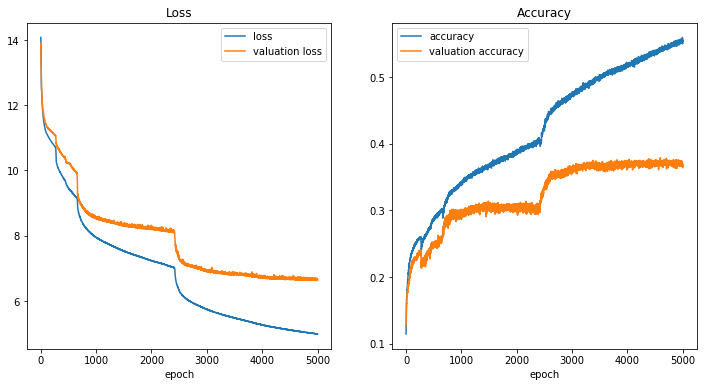

In [34]:
history=result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

## Dense Neural Network

In [21]:
def build_model(hidden1,hidden2,dropout):
    model=keras.Sequential([
        keras.layers.Flatten(input_shape=(20,173)),
        keras.layers.Dense(hidden1,activation="relu"),
        keras.layers.Dense(hidden2,activation="relu"),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(num_classes,activation="softmax")
    ])
    #optimizer=keras.optimizers.Adam(lr=0.0002)
    optimizer=keras.optimizers.SGD(lr=0.001) # for some reason Adam's does not converge for this dataset, but plain SGD does
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

### Fit 2 layer Dense Network with 40% Dropout

In [22]:
model0=build_model(512,256,0.4)
model0.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-04-20 10:10:38,779|From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3460)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1772032   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
drop

In [23]:
result=model0.fit(features_train,labels_train,validation_data=(features_val,labels_val),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[LoggingCallback(50,logger)])

2019-04-20 10:10:39,727|	0: TRAIN loss 13.9174,  acc 0.1314  ||  VAL loss 13.7047, acc 0.1479
2019-04-20 10:10:55,852|	50: TRAIN loss 9.6454,  acc 0.3884  ||  VAL loss 9.5682, acc 0.3900
2019-04-20 10:11:11,987|	100: TRAIN loss 2.1122,  acc 0.3393  ||  VAL loss 2.0542, acc 0.3932
2019-04-20 10:11:28,083|	150: TRAIN loss 1.1723,  acc 0.5988  ||  VAL loss 1.2602, acc 0.6250
2019-04-20 10:11:44,152|	200: TRAIN loss 0.9438,  acc 0.6631  ||  VAL loss 1.1196, acc 0.6669
2019-04-20 10:12:00,347|	250: TRAIN loss 0.8282,  acc 0.7049  ||  VAL loss 1.0541, acc 0.6764
2019-04-20 10:12:16,470|	300: TRAIN loss 0.7469,  acc 0.7356  ||  VAL loss 0.9791, acc 0.7128
2019-04-20 10:12:32,571|	350: TRAIN loss 0.6489,  acc 0.7718  ||  VAL loss 1.0472, acc 0.7002
2019-04-20 10:12:48,644|	400: TRAIN loss 0.5987,  acc 0.7935  ||  VAL loss 1.0225, acc 0.7286
2019-04-20 10:13:04,749|	450: TRAIN loss 0.5255,  acc 0.8183  ||  VAL loss 1.1669, acc 0.7215
2019-04-20 10:13:20,840|	500: TRAIN loss 0.4874,  acc 0.8304 

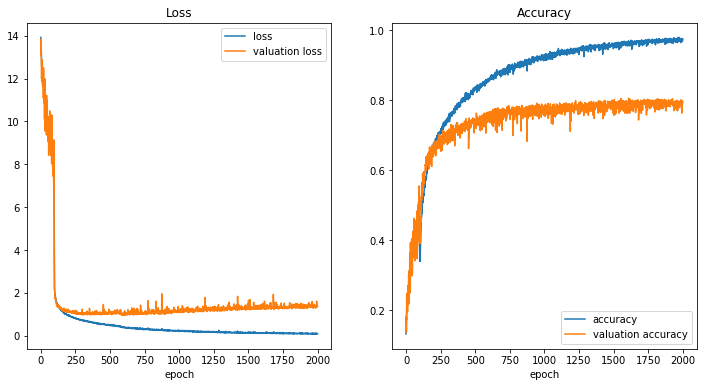

In [24]:
history=result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [25]:
Y_pred=np.argmax(model0.predict(features_val),axis=1)
np.mean(Y_pred==labels_val)

0.7935126582278481

### Fit 2 Layer Dense Network without Dropout

In [26]:
model1=build_model(512,256,0.0)
result=model1.fit(features_train,labels_train,validation_data=(features_val,labels_val),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[LoggingCallback(50,logger)])

2019-04-20 10:21:28,068|	0: TRAIN loss 14.2787,  acc 0.1116  ||  VAL loss 14.1549, acc 0.1210
2019-04-20 10:21:44,078|	50: TRAIN loss 7.7389,  acc 0.4622  ||  VAL loss 7.7754, acc 0.4517
2019-04-20 10:22:00,180|	100: TRAIN loss 0.8102,  acc 0.7300  ||  VAL loss 1.4118, acc 0.6155
2019-04-20 10:22:16,198|	150: TRAIN loss 0.6067,  acc 0.8027  ||  VAL loss 1.3710, acc 0.6551
2019-04-20 10:22:32,596|	200: TRAIN loss 0.4202,  acc 0.8700  ||  VAL loss 1.4529, acc 0.6519
2019-04-20 10:22:49,426|	250: TRAIN loss 0.3292,  acc 0.9048  ||  VAL loss 1.2201, acc 0.7025
2019-04-20 10:23:06,188|	300: TRAIN loss 0.2599,  acc 0.9325  ||  VAL loss 1.2430, acc 0.7326
2019-04-20 10:23:22,209|	350: TRAIN loss 0.1998,  acc 0.9531  ||  VAL loss 1.2612, acc 0.7358
2019-04-20 10:23:38,216|	400: TRAIN loss 0.1862,  acc 0.9606  ||  VAL loss 1.2571, acc 0.7492
2019-04-20 10:23:54,327|	450: TRAIN loss 0.1521,  acc 0.9715  ||  VAL loss 1.4175, acc 0.7334
2019-04-20 10:24:10,327|	500: TRAIN loss 0.2426,  acc 0.9473 

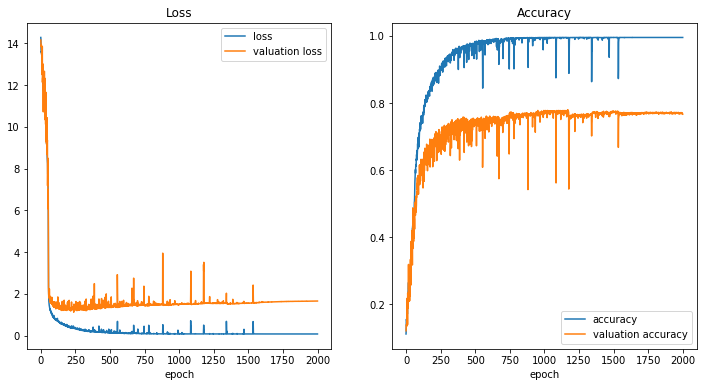

In [27]:
history=result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [28]:
Y_pred=np.argmax(model1.predict(features_val),axis=1)
np.mean(Y_pred==labels_val)

0.7666139240506329

Drop out does not really make a difference in this case.

### Hyper-parameter optimization

In [35]:
dropout=0.4

In [36]:
results=[]
for n_layer1 in [128,256,2*256,4*256,8*256]:
    for n_layer2 in [32,64,128,256,2*256,4*256]:
        # Build the Estimator
        model=build_model(n_layer1,n_layer2,dropout)
        model.fit(features_train,labels_train,validation_data=(features_val,labels_val),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[LoggingCallback(100,logger)])
        Y_pred=np.argmax(model.predict(features_train),axis=1)
        acc_train=np.mean(Y_pred==labels_train)
        Y_pred=np.argmax(model.predict(features_val),axis=1)
        acc_val=np.mean(Y_pred==labels_val)
        logger.info(f">>>>>{n_layer1},{n_layer2},{acc_train},{acc_val}")
        results.append((n_layer1,n_layer2,acc_train,acc_val))
        

2019-04-20 10:56:44,439|	0: TRAIN loss 13.5888,  acc 0.1348  ||  VAL loss 13.4544, acc 0.1337
2019-04-20 10:57:14,733|	100: TRAIN loss 2.1248,  acc 0.1934  ||  VAL loss 2.1371, acc 0.1978
2019-04-20 10:57:45,140|	200: TRAIN loss 2.0342,  acc 0.2169  ||  VAL loss 2.1099, acc 0.2168
2019-04-20 10:58:15,571|	300: TRAIN loss 1.9116,  acc 0.2609  ||  VAL loss 2.0483, acc 0.2737
2019-04-20 10:58:45,984|	400: TRAIN loss 1.8156,  acc 0.3038  ||  VAL loss 1.9193, acc 0.3457
2019-04-20 10:59:16,367|	500: TRAIN loss 1.6589,  acc 0.3624  ||  VAL loss 1.8373, acc 0.4051
2019-04-20 10:59:46,760|	600: TRAIN loss 1.5554,  acc 0.4175  ||  VAL loss 1.7581, acc 0.4945
2019-04-20 11:00:17,281|	700: TRAIN loss 1.4463,  acc 0.4543  ||  VAL loss 1.6265, acc 0.5356
2019-04-20 11:00:47,699|	800: TRAIN loss 1.3618,  acc 0.4899  ||  VAL loss 1.6979, acc 0.5229
2019-04-20 11:01:17,972|	900: TRAIN loss 1.2534,  acc 0.5333  ||  VAL loss 1.5663, acc 0.5696
2019-04-20 11:01:48,360|	1000: TRAIN loss 1.1545,  acc 0.561

2019-04-20 11:39:33,728|	400: TRAIN loss 1.8382,  acc 0.3137  ||  VAL loss 2.0303, acc 0.2769
2019-04-20 11:40:04,445|	500: TRAIN loss 1.7495,  acc 0.3565  ||  VAL loss 1.9832, acc 0.3291
2019-04-20 11:40:35,071|	600: TRAIN loss 1.6657,  acc 0.3884  ||  VAL loss 2.1399, acc 0.3623
2019-04-20 11:41:05,743|	700: TRAIN loss 1.5532,  acc 0.4256  ||  VAL loss 1.9281, acc 0.3679
2019-04-20 11:41:36,352|	800: TRAIN loss 1.4330,  acc 0.4669  ||  VAL loss 1.8818, acc 0.3853
2019-04-20 11:42:07,101|	900: TRAIN loss 1.2754,  acc 0.5388  ||  VAL loss 1.7964, acc 0.4810
2019-04-20 11:42:37,837|	1000: TRAIN loss 1.1348,  acc 0.6000  ||  VAL loss 1.6000, acc 0.5301
2019-04-20 11:43:08,466|	1100: TRAIN loss 1.0397,  acc 0.6382  ||  VAL loss 1.5971, acc 0.5222
2019-04-20 11:43:39,228|	1200: TRAIN loss 1.1137,  acc 0.6079  ||  VAL loss 1.6523, acc 0.5150
2019-04-20 11:44:09,966|	1300: TRAIN loss 0.9526,  acc 0.6681  ||  VAL loss 1.5296, acc 0.5736
2019-04-20 11:44:40,688|	1400: TRAIN loss 0.9103,  acc 0

2019-04-20 12:23:27,586|	800: TRAIN loss 0.4714,  acc 0.8401  ||  VAL loss 1.1194, acc 0.7429
2019-04-20 12:23:59,187|	900: TRAIN loss 0.4484,  acc 0.8401  ||  VAL loss 1.1902, acc 0.7278
2019-04-20 12:24:30,686|	1000: TRAIN loss 0.3739,  acc 0.8739  ||  VAL loss 1.2267, acc 0.7563
2019-04-20 12:25:02,158|	1100: TRAIN loss 0.3697,  acc 0.8745  ||  VAL loss 1.2852, acc 0.7453
2019-04-20 12:25:33,823|	1200: TRAIN loss 0.3285,  acc 0.8846  ||  VAL loss 1.2810, acc 0.7595
2019-04-20 12:26:05,479|	1300: TRAIN loss 0.3043,  acc 0.9004  ||  VAL loss 1.3438, acc 0.7278
2019-04-20 12:26:36,934|	1400: TRAIN loss 0.2863,  acc 0.9141  ||  VAL loss 1.3354, acc 0.7714
2019-04-20 12:27:08,478|	1500: TRAIN loss 0.2594,  acc 0.9175  ||  VAL loss 1.4114, acc 0.7579
2019-04-20 12:27:39,947|	1600: TRAIN loss 0.2317,  acc 0.9236  ||  VAL loss 1.7458, acc 0.7271
2019-04-20 12:28:12,618|	1700: TRAIN loss 0.2344,  acc 0.9236  ||  VAL loss 1.8477, acc 0.7294
2019-04-20 12:28:46,286|	1800: TRAIN loss 0.2179,  a

2019-04-20 13:08:48,811|	1200: TRAIN loss 0.8501,  acc 0.6688  ||  VAL loss 1.4455, acc 0.6725
2019-04-20 13:09:22,259|	1300: TRAIN loss 0.7794,  acc 0.6896  ||  VAL loss 1.3509, acc 0.6582
2019-04-20 13:09:56,457|	1400: TRAIN loss 0.6830,  acc 0.7282  ||  VAL loss 1.8453, acc 0.6733
2019-04-20 13:10:31,539|	1500: TRAIN loss 0.6366,  acc 0.7407  ||  VAL loss 1.4376, acc 0.7168
2019-04-20 13:11:05,217|	1600: TRAIN loss 0.5563,  acc 0.7807  ||  VAL loss 1.3538, acc 0.7223
2019-04-20 13:11:38,855|	1700: TRAIN loss 0.5783,  acc 0.7692  ||  VAL loss 1.4294, acc 0.7247
2019-04-20 13:12:12,545|	1800: TRAIN loss 0.4698,  acc 0.8118  ||  VAL loss 1.5657, acc 0.7373
2019-04-20 13:12:46,114|	1900: TRAIN loss 0.4647,  acc 0.8120  ||  VAL loss 1.4228, acc 0.7508
2019-04-20 13:13:19,919|>>>>>512,32,0.9465558194774347,0.7515822784810127
2019-04-20 13:13:21,619|	0: TRAIN loss 14.2810,  acc 0.1103  ||  VAL loss 14.4095, acc 0.1060
2019-04-20 13:13:55,097|	100: TRAIN loss 2.4015,  acc 0.1494  ||  VAL lo

2019-04-20 13:56:17,806|	1600: TRAIN loss 0.1862,  acc 0.9436  ||  VAL loss 1.4787, acc 0.7191
2019-04-20 13:56:51,875|	1700: TRAIN loss 0.1774,  acc 0.9468  ||  VAL loss 1.4931, acc 0.7278
2019-04-20 13:57:25,896|	1800: TRAIN loss 0.2075,  acc 0.9406  ||  VAL loss 1.5204, acc 0.7278
2019-04-20 13:58:00,036|	1900: TRAIN loss 0.1611,  acc 0.9563  ||  VAL loss 1.4699, acc 0.7373
2019-04-20 13:58:34,291|>>>>>512,512,0.9726840855106889,0.7262658227848101
2019-04-20 13:58:36,209|	0: TRAIN loss 14.1095,  acc 0.1196  ||  VAL loss 12.7897, acc 0.1954
2019-04-20 13:59:11,512|	100: TRAIN loss 1.5308,  acc 0.4826  ||  VAL loss 1.7370, acc 0.4636
2019-04-20 13:59:48,040|	200: TRAIN loss 1.4031,  acc 0.5101  ||  VAL loss 1.7026, acc 0.4763
2019-04-20 14:00:24,574|	300: TRAIN loss 1.2628,  acc 0.5588  ||  VAL loss 1.6791, acc 0.5055
2019-04-20 14:01:01,243|	400: TRAIN loss 1.1999,  acc 0.5962  ||  VAL loss 1.5093, acc 0.5380
2019-04-20 14:01:37,047|	500: TRAIN loss 1.0326,  acc 0.6423  ||  VAL loss 

2019-04-20 15:26:44,070|>>>>>1024,128,0.9920823436262867,0.8014240506329114
2019-04-20 15:26:50,197|	0: TRAIN loss 14.2549,  acc 0.1126  ||  VAL loss 13.7127, acc 0.1479
2019-04-20 15:32:42,420|	100: TRAIN loss 8.8245,  acc 0.4333  ||  VAL loss 8.2538, acc 0.4699
2019-04-20 15:38:34,435|	200: TRAIN loss 1.0141,  acc 0.6328  ||  VAL loss 1.2961, acc 0.6084
2019-04-20 15:44:27,318|	300: TRAIN loss 0.6772,  acc 0.7468  ||  VAL loss 1.0008, acc 0.7160
2019-04-20 15:50:19,698|	400: TRAIN loss 0.5348,  acc 0.8110  ||  VAL loss 0.9950, acc 0.7255
2019-04-20 15:56:10,460|	500: TRAIN loss 0.3942,  acc 0.8599  ||  VAL loss 1.0828, acc 0.7271
2019-04-20 16:02:02,905|	600: TRAIN loss 0.3293,  acc 0.8858  ||  VAL loss 0.9957, acc 0.7587
2019-04-20 16:07:55,963|	700: TRAIN loss 0.2662,  acc 0.9066  ||  VAL loss 0.9808, acc 0.7824
2019-04-20 16:13:48,124|	800: TRAIN loss 0.2420,  acc 0.9208  ||  VAL loss 0.9806, acc 0.7927
2019-04-20 16:19:38,202|	900: TRAIN loss 0.1783,  acc 0.9380  ||  VAL loss 1.0

2019-04-20 23:17:08,893|	300: TRAIN loss 1.6089,  acc 0.3939  ||  VAL loss 1.8380, acc 0.4130
2019-04-20 23:30:23,629|	400: TRAIN loss 1.3146,  acc 0.5065  ||  VAL loss 1.4608, acc 0.5261
2019-04-20 23:43:38,055|	500: TRAIN loss 1.0557,  acc 0.6083  ||  VAL loss 1.2634, acc 0.6195
2019-04-20 23:56:52,845|	600: TRAIN loss 0.7654,  acc 0.7039  ||  VAL loss 1.2901, acc 0.6685
2019-04-21 00:10:12,806|	700: TRAIN loss 0.6007,  acc 0.7654  ||  VAL loss 1.0820, acc 0.7089
2019-04-21 00:28:03,004|	800: TRAIN loss 0.4606,  acc 0.8211  ||  VAL loss 1.0737, acc 0.7524
2019-04-21 00:46:05,031|	900: TRAIN loss 0.3730,  acc 0.8541  ||  VAL loss 1.0677, acc 0.7627
2019-04-21 01:04:03,190|	1000: TRAIN loss 0.3097,  acc 0.8791  ||  VAL loss 1.0324, acc 0.7698
2019-04-21 01:22:01,816|	1100: TRAIN loss 0.2763,  acc 0.8977  ||  VAL loss 1.3318, acc 0.7516
2019-04-21 01:39:59,464|	1200: TRAIN loss 0.2134,  acc 0.9186  ||  VAL loss 1.1314, acc 0.7809
2019-04-21 01:57:59,358|	1300: TRAIN loss 0.1949,  acc 0.

2019-04-21 07:00:07,814|	700: TRAIN loss 0.1508,  acc 0.9800  ||  VAL loss 0.9703, acc 0.8354
2019-04-21 07:00:58,048|	800: TRAIN loss 0.1479,  acc 0.9784  ||  VAL loss 0.9659, acc 0.8354
2019-04-21 07:01:48,181|	900: TRAIN loss 0.1164,  acc 0.9889  ||  VAL loss 0.9486, acc 0.8449
2019-04-21 07:02:38,386|	1000: TRAIN loss 0.1116,  acc 0.9901  ||  VAL loss 0.9888, acc 0.8426
2019-04-21 07:03:28,437|	1100: TRAIN loss 0.1019,  acc 0.9915  ||  VAL loss 0.9942, acc 0.8347
2019-04-21 07:04:18,781|	1200: TRAIN loss 0.1055,  acc 0.9907  ||  VAL loss 1.0037, acc 0.8410
2019-04-21 07:05:08,980|	1300: TRAIN loss 0.0977,  acc 0.9933  ||  VAL loss 0.9945, acc 0.8394
2019-04-21 07:05:59,210|	1400: TRAIN loss 0.1021,  acc 0.9917  ||  VAL loss 1.0458, acc 0.8386
2019-04-21 07:06:49,399|	1500: TRAIN loss 0.0989,  acc 0.9919  ||  VAL loss 1.0158, acc 0.8386
2019-04-21 07:07:39,636|	1600: TRAIN loss 0.0947,  acc 0.9931  ||  VAL loss 1.0438, acc 0.8378
2019-04-21 07:08:29,812|	1700: TRAIN loss 0.0966,  ac

In [37]:
import pandas as pd

In [38]:
data=pd.DataFrame(results,columns=["layer1","layer2","train","valuation"])
data.head()

,layer1,layer2,train,valuation
0,128,32,0.863618,0.684335
1,128,64,0.923990,0.718354
2,128,128,0.784046,0.595728
3,128,256,0.734363,0.595728
4,128,512,0.785827,0.604430


In [39]:
pivot=data.pivot('layer1', 'layer2')
pivot

train                                                   valuation  \
layer2      32        64        128       256       512       1024      32     
layer1                                                                         
128     0.863618  0.923990  0.784046  0.734363  0.785827  0.820269  0.684335   
256     0.861639  0.960412  0.980998  0.991686  0.741686  0.932304  0.695411   
512     0.946556  0.982977  0.990103  0.997823  0.972684  0.901029  0.751582   
1024    0.969319  0.971694  0.992082  0.993072  0.993864  0.997229  0.764241   
2048    0.988915  0.996833  0.995645  0.998416  0.994458  0.994656  0.795886   

                                                          
layer2      64        128       256       512       1024  
layer1                                                    
128     0.718354  0.595728  0.595728  0.604430  0.610759  
256     0.737342  0.764241  0.781646  0.583861  0.681171  
512     0.756329  0.765032  0.799842  0.726266  0.687500  
1024    0.756329  0.801424  0.810918  0.809335  0.797468  
2048    0.815665  0.787184  0.818829  0.824367  0.841772

We have to go to **extremly large** model sizes ($2048\times 1024$) to start seeing performance degradation (the variance on the bias-variance trade-off)

Optimal model seems to be **$2048 \times 1024$**, but we would probably need to run cross-validation to gain any certainty,

In [40]:
from matplotlib import colors, ticker, cm

In [41]:
X=pivot.columns.levels[1].values
Y=pivot.index.values
Z=data["valuation"].values.reshape(len(X),-1).T
print(X.shape,Y.shape,Z.shape)
Xi,Yi = np.meshgrid(X, Y)

(6,) (5,) (5, 6)


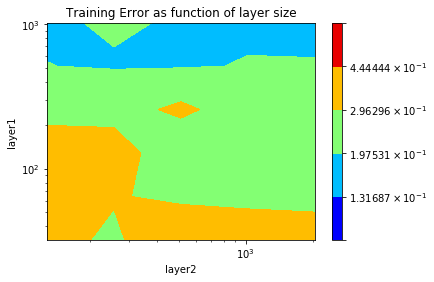

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Training Error as function of layer size")
ax.set_xlabel("layer2")
ax.set_ylabel("layer1")
ax.set_xscale("log")
ax.set_yscale("log")
cs=plt.contourf(Yi, Xi, 1-Z,locator=ticker.LogLocator(base=1.5,numdecs=10),  cmap=plt.cm.jet)
cbar = fig.colorbar(cs)

### Test of the best model

In [43]:
best_idx=data["valuation"].idxmax()
best=data.iloc[best_idx]
best_hidden1=best["layer1"]
best_hidden2=best["layer2"]
best

layer1       2048.000000
layer2       1024.000000
train           0.994656
valuation       0.841772
Name: 29, dtype: float64

In [44]:
best_model=build_model(best_hidden1,best_hidden2,dropout)
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 3460)              0         
_________________________________________________________________
dense_103 (Dense)            (None, 2048)              7088128   
_________________________________________________________________
dense_104 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_33 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 10)                10250     
Total params: 9,196,554
Trainable params: 9,196,554
Non-trainable params: 0
_________________________________________________________________


In [45]:
best_result=best_model.fit(features,labels,validation_data=(features_test,labels_test),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[LoggingCallback(50,logger)])

2019-04-21 07:11:04,499|	0: TRAIN loss 13.7627,  acc 0.1396  ||  VAL loss 13.5421, acc 0.1577
2019-04-21 07:11:35,884|	50: TRAIN loss 10.7999,  acc 0.3246  ||  VAL loss 10.6785, acc 0.3344
2019-04-21 07:12:07,340|	100: TRAIN loss 10.1948,  acc 0.3575  ||  VAL loss 9.5765, acc 0.3984
2019-04-21 07:12:38,743|	150: TRAIN loss 7.6083,  acc 0.4986  ||  VAL loss 7.8079, acc 0.4839
2019-04-21 07:13:10,286|	200: TRAIN loss 0.7121,  acc 0.7750  ||  VAL loss 1.1325, acc 0.7125
2019-04-21 07:13:41,666|	250: TRAIN loss 0.4631,  acc 0.8583  ||  VAL loss 0.7865, acc 0.7897
2019-04-21 07:14:13,125|	300: TRAIN loss 0.3786,  acc 0.8936  ||  VAL loss 0.7513, acc 0.8125
2019-04-21 07:14:44,508|	350: TRAIN loss 0.2521,  acc 0.9359  ||  VAL loss 0.8262, acc 0.7891
2019-04-21 07:15:15,919|	400: TRAIN loss 0.1978,  acc 0.9440  ||  VAL loss 1.1926, acc 0.7315
2019-04-21 07:15:47,331|	450: TRAIN loss 0.1668,  acc 0.9538  ||  VAL loss 0.6883, acc 0.8429
2019-04-21 07:16:18,834|	500: TRAIN loss 0.1188,  acc 0.97

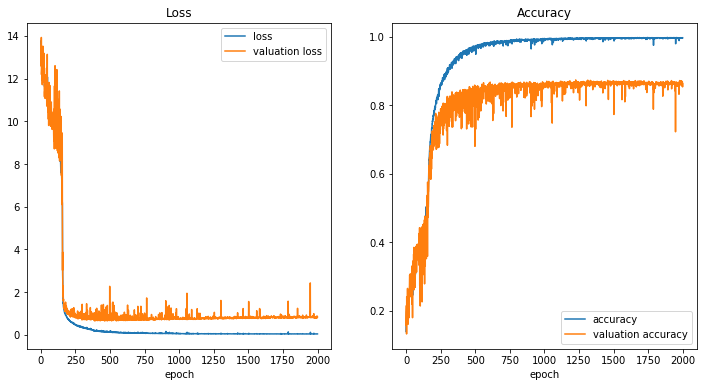

In [46]:
history=best_result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [47]:
Y_pred=np.argmax(best_model.predict(features_test),axis=1)
np.mean(Y_pred==labels_test)

0.863204559848005